In [71]:
import torch
from training.FiretraceMLP import FiretraceMLP

checkpoint = torch.load("../models/firetrace_model.pt")

model = FiretraceMLP(width=checkpoint['model_size'][0], depth=checkpoint['model_size'][1])
compiled_model = torch.compile(model, fullgraph=True, mode="max-autotune")

compiled_model.load_state_dict(checkpoint['model_state_dict'])
compiled_model.eval()

OptimizedModule(
  (_orig_mod): FiretraceMLP(
    (layers): ModuleList(
      (0): Linear(in_features=9, out_features=30, bias=True)
      (1): ReLU()
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): ReLU()
      (4): Linear(in_features=30, out_features=30, bias=True)
      (5): ReLU()
      (6): Linear(in_features=30, out_features=30, bias=True)
      (7): ReLU()
      (8): Linear(in_features=30, out_features=30, bias=True)
      (9): ReLU()
      (10): Linear(in_features=30, out_features=30, bias=True)
      (11): ReLU()
      (12): Linear(in_features=30, out_features=30, bias=True)
      (13): ReLU()
      (14): Linear(in_features=30, out_features=30, bias=True)
      (15): ReLU()
      (16): Linear(in_features=30, out_features=30, bias=True)
      (17): ReLU()
      (18): Linear(in_features=30, out_features=30, bias=True)
      (19): ReLU()
      (20): Linear(in_features=30, out_features=30, bias=True)
      (21): ReLU()
      (22): Linear(in_features=30, ou

In [72]:
import pandas as pd

df = pd.read_csv("../data/gen_2/processed/with_fire_area_soi_weather_time.csv")

# Pick last x rows
df = df.tail(500)

y = df["fire_area"]
y = y.reset_index()["fire_area"]
X = df.drop("fire_area", axis=1)

In [73]:
import joblib

x_scaler = joblib.load("../models/x_scaler.save")
y_scaler = joblib.load("../models/y_scaler.save")

x_scaled = x_scaler.transform(X)

In [74]:
print(x_scaled[0].shape)

(9,)


In [75]:
individual_output = compiled_model(torch.tensor(x_scaled[70], dtype=torch.float32).reshape(1, -1))
individual_output_unscaled = y_scaler.inverse_transform(individual_output.detach().numpy().reshape(1, -1))

print("Predicted fire area: ", individual_output_unscaled)

print("Actual fire area: ", y[70])

Predicted fire area:  [[331.3428]]
Actual fire area:  834.72


In [76]:
test_output = compiled_model(torch.tensor(x_scaled, dtype=torch.float32))

test_output

tensor([[0.0264],
        [0.0197],
        [0.0246],
        [0.0219],
        [0.0225],
        [0.0213],
        [0.0248],
        [0.0219],
        [0.0253],
        [0.0221],
        [0.0388],
        [0.0297],
        [0.0245],
        [0.0252],
        [0.0258],
        [0.0251],
        [0.0250],
        [0.0312],
        [0.0276],
        [0.0431],
        [0.0436],
        [0.0351],
        [0.0256],
        [0.0353],
        [0.0382],
        [0.0297],
        [0.0482],
        [0.0805],
        [0.0444],
        [0.0371],
        [0.0644],
        [0.0638],
        [0.0585],
        [0.0376],
        [0.0470],
        [0.0740],
        [0.0555],
        [0.0570],
        [0.0440],
        [0.0968],
        [0.0662],
        [0.0530],
        [0.0425],
        [0.0294],
        [0.0891],
        [0.0379],
        [0.0411],
        [0.0462],
        [0.0372],
        [0.0693],
        [0.0300],
        [0.0302],
        [0.0557],
        [0.0370],
        [0.0422],
        [0

In [77]:
# Unscale the output

y_unscaled = y_scaler.inverse_transform(test_output.detach().numpy())

y_unscaled

array([[ 349.92688 ],
       [ 262.4241  ],
       [ 326.51566 ],
       [ 291.4309  ],
       [ 298.64133 ],
       [ 282.91953 ],
       [ 328.9096  ],
       [ 290.9931  ],
       [ 335.5333  ],
       [ 293.58868 ],
       [ 514.60547 ],
       [ 393.6702  ],
       [ 325.36685 ],
       [ 335.0945  ],
       [ 342.24002 ],
       [ 333.63297 ],
       [ 332.55298 ],
       [ 413.78314 ],
       [ 366.56055 ],
       [ 572.0943  ],
       [ 578.92175 ],
       [ 465.21826 ],
       [ 339.48483 ],
       [ 468.1658  ],
       [ 507.38147 ],
       [ 394.7859  ],
       [ 639.8277  ],
       [1067.4806  ],
       [ 589.4712  ],
       [ 492.21564 ],
       [ 853.39667 ],
       [ 845.28937 ],
       [ 776.1661  ],
       [ 499.22168 ],
       [ 623.5099  ],
       [ 980.55035 ],
       [ 735.70355 ],
       [ 756.02637 ],
       [ 584.0766  ],
       [1282.4486  ],
       [ 878.07904 ],
       [ 703.0727  ],
       [ 563.1578  ],
       [ 389.70938 ],
       [1180.0535  ],
       [ 5

In [78]:
# Calculate MAE

from sklearn.metrics import mean_absolute_error

mean_absolute_error(y, y_unscaled)

190.38526889282227

Text(0, 0.5, 'Fire Area (sqkm)')

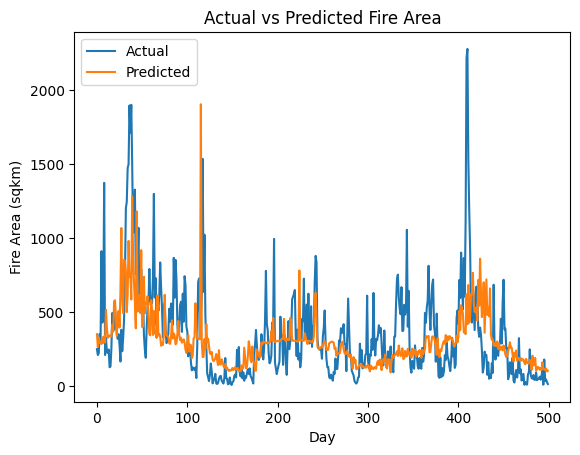

In [79]:
# Graph output vs actual

import matplotlib.pyplot as plt

plt.plot(y, label="Actual")
plt.plot(y_unscaled, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Fire Area")
plt.xlabel("Day")
plt.ylabel("Fire Area (sqkm)")

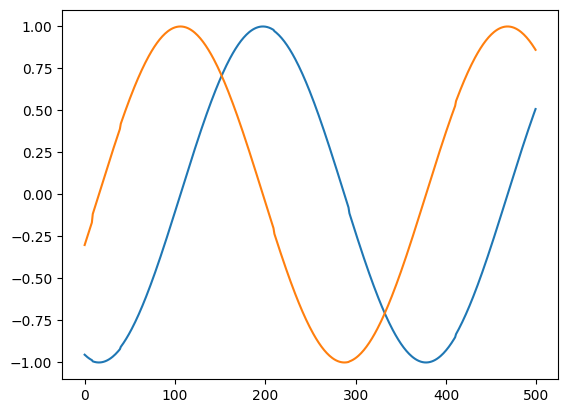

In [80]:
plt.plot(X['sin_signal'].to_numpy())
plt.plot(X['cos_signal'].to_numpy())

